In [16]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# All files in src directory
from engine import Engine
from models import UNet, DiffusionLSTM, DiffusionTransformer
from frameworks import Diffusion
from utils import plot_comparison, evaluate_model, visualize_all, plot_loss_comparison, load_checkpoint
from utils.paths import VISUALIZATION_DIR, RESULTS_DIR
from ingestion import read_equity, TSFinDataset
from preprocessing import to_time_bars, to_volume_bars, to_dollar_bars

VISUALIZATION_DIR.mkdir(parents=True, exist_ok=True)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from matplotlib.table import Table

# ==========================================
# 🛠️ Helper Function: ตัวช่วย Save (High Quality)
# ==========================================
def save_smart_hq(ani, filename, fps):
    """
    Save แบบ High Quality (MP4 Priority)
    - Bitrate สูง
    - DPI สูง
    """
    try:
        print(f"💾 Rendering High Quality MP4 (60fps): {filename} ...")
        # extra_args=['-vcodec', 'libx264'] ช่วยให้ไฟล์เข้ากันได้ดีกับ Player ส่วนใหญ่
        ani.save(filename, writer='ffmpeg', fps=fps, dpi=100, bitrate=5000, 
                 extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        print(f"✅ Success! Saved to: {filename}")
    except Exception as e:
        print(f"⚠️ FFmpeg Error ({e}). Switching to GIF (Low Quality)...")
        gif_filename = filename.replace(".mp4", ".gif")
        ani.save(gif_filename, writer='pillow', fps=fps) # GIF ทำ bitrate ไม่ได้
        print(f"✅ Saved as GIF instead: {gif_filename}")

# ==========================================
# ฟังก์ชันรวมร่าง (Combined Graph + Table) - FULL HD 60FPS
# ==========================================
def animate_combined_hq(df, window_size=60, stride=1, fps=60, output_file="anim_hq.mp4", price_col='Close'):
    
    # Setup Figure แบบ 1080p (19.2 x 10.8 นิ้ว * 100 dpi = 1920x1080 pixels)
    fig, (ax_graph, ax_table) = plt.subplots(2, 1, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [2, 1]})
    
    # --- Part 1: Graph Setup ---
    if price_col not in df.columns: price_col = df.columns[0]
    
    # เส้นกราฟหนาขึ้นหน่อย (linewidth=2) เพื่อให้เห็นชัดในจอใหญ่
    ax_graph.plot(df.index, df[price_col], color='#0052cc', alpha=0.8, linewidth=2, label='Price')
    
    # แต่ง Font ให้ใหญ่ขึ้น
    ax_graph.set_title(f"Sliding Window Visualization (Size={window_size})", fontsize=24, fontweight='bold', pad=20)
    ax_graph.set_ylabel(price_col, fontsize=16)
    ax_graph.tick_params(axis='both', which='major', labelsize=12)
    ax_graph.grid(True, linestyle='--', alpha=0.5)
    
    # Setup Scale
    min_p, max_p = df[price_col].min(), df[price_col].max()
    pad = (max_p - min_p) * 0.1
    ax_graph.set_ylim(min_p - pad, max_p + pad)
    
    # Setup Sliding Box
    rect = Rectangle((df.index[0], min_p - pad), 
                     pd.Timedelta(days=window_size), 
                     (max_p - min_p) + 2*pad, 
                     facecolor='#ff3333', alpha=0.25, edgecolor='#ff0000', linewidth=2)
    ax_graph.add_patch(rect)
    
    # Text บอกสถานะมุมซ้ายบน
    status_text = ax_graph.text(0.02, 0.93, '', transform=ax_graph.transAxes, fontsize=16,
                                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.9))

    # --- Part 2: Table Setup ---
    # โชว์ข้อมูลเยอะขึ้นหน่อยเพราะจอใหญ่ (30 แถว)
    display_df = df.iloc[:30, :4].copy() # เอา 4 คอลัมน์แรก
    n_rows = len(display_df)
    ax_table.axis('off')
    
    table = Table(ax_table, bbox=[0, 0, 1, 1])
    col_labels = ['Index'] + display_df.columns.tolist()
    table_vals = display_df.reset_index().values
    
    cells = {}
    for i in range(n_rows + 1):
        for j in range(len(col_labels)):
            # 🟢 FIX: จัดฟอร์แมตตัวเลขให้แสดงทศนิยม 4 ตำแหน่ง
            if i == 0:
                txt = col_labels[j]
            else:
                val = table_vals[i-1, j]
                if isinstance(val, (int, float, np.number)):
                    txt = f"{val:.4f}" # แสดงทศนิยม 4 ตำแหน่ง
                else:
                    txt = str(val)
            
            # Header สีเทาเข้ม, Data สีขาว
            facecolor = '#dddddd' if i==0 else 'white'
            edgecolor = 'black'
            
            # Font size ใหญ่ขึ้น
            fontsize = 14 if i==0 else 12
            fontweight = 'bold' if i==0 else 'normal'

            cells[(i,j)] = table.add_cell(i, j, 1/(n_rows+1), 1/len(col_labels), 
                                          text=txt, loc='center', 
                                          facecolor=facecolor, edgecolor=edgecolor)
            cells[(i,j)].set_text_props(fontsize=fontsize, fontweight=fontweight)
    
    # ปรับความกว้างคอลัมน์อัตโนมัติ
    col_indices = list(range(len(col_labels)))
    table.auto_set_column_width(col_indices)
    
    ax_table.add_table(table)

    # --- Update Logic ---
    total_frames = len(df) - window_size + 1
    
    def update(frame):
        start = frame * stride
        end = start + window_size
        
        # 1. Update Graph
        if start < len(df):
             rect.set_xy((df.index[start], min_p - pad))
             status_text.set_text(f"Step: {frame} | Window Range: {start} - {end-1}")
        
        # 2. Update Table (Reset สี + Highlight ใหม่)
        # Reset
        for i in range(1, n_rows + 1):
            for j in range(len(col_labels)):
                cells[(i,j)].set_facecolor('white')
        
        # Highlight (สีเหลืองทอง)
        for idx in range(start, end):
            row_idx = idx + 1
            if row_idx <= n_rows:
                for j in range(len(col_labels)):
                    cells[(row_idx, j)].set_facecolor('#FFFACD') # LemonChiffon (ดูสบายตากว่าเหลืองสด)
                    cells[(row_idx, j)].set_edgecolor('#FFD700') # ขอบสีทอง
                    cells[(row_idx, j)].set_linewidth(2)

        return rect, table, status_text

    print(f"🚀 Initializing Animation... (Frames: {total_frames})")
    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=False, repeat=False)
    
    # Save HQ
    save_smart_hq(ani, output_file, fps)
    plt.close(fig)

In [9]:
df = read_equity("AAPL")
df.head(3)
# df["Close"].plot(figsize=(15, 7))

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261047,24.729270,23.821672,24.718174,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579794,23.839424,23.218085,23.641928,263188400


In [10]:
from matplotlib.patches import Rectangle
from matplotlib.table import Table
import matplotlib.animation as animation
# animate_graph_only(df, window_size=20, output_file="demo_graph.mp4")

#     # 2. สร้างแค่ตาราง
# animate_table_only(df, window_size=5, output_file="demo_table.mp4")

#     # 3. สร้างรวมกัน
# animate_combined(df, window_size=10, output_file="demo_combined.mp4")

animate_combined_hq(
        df, 
        window_size=30, # Window 30 วัน
        stride=1,       # เลื่อนทีละ 1 วัน
        fps=60,         # ลื่นหัวแตก
        output_file="demo_fullhd_60fps.mp4"
    )

MovieWriter ffmpeg unavailable; using Pillow instead.


🚀 Initializing Animation... (Frames: 2695)
💾 Rendering High Quality MP4 (60fps): demo_fullhd_60fps.mp4 ...
⚠️ FFmpeg Error (AbstractMovieWriter.__init__() got an unexpected keyword argument 'extra_args'). Switching to GIF (Low Quality)...
✅ Saved as GIF instead: demo_fullhd_60fps.gif


In [3]:
def plot_multi_model_comparison(
    dataloader, 
    models_config, # 👈 รับ List ของโมเดลที่จะเทียบ
    diffusion, 
    scaler, 
    dataset, 
    device="cuda"
):
    """
    เปรียบเทียบผลลัพธ์จากหลายโมเดลในกราฟเดียว
    models_config structure:
    [
        {"name": "UNet", "model": unet_obj, "path": "path/to/unet.pt", "color": "red"},
        {"name": "LSTM", "model": lstm_obj, "path": "path/to/lstm.pt", "color": "green"},
        ...
    ]
    """
    
    # -------------------------------------------------------
    # 1. 📥 เตรียมข้อมูลจริง (Real Data) - ใช้เป็นฐานเทียบ
    # -------------------------------------------------------
    batch = next(iter(dataloader))
    real_sample_raw = batch['x_raw'][0].cpu().numpy() # [L, C]

    # -------------------------------------------------------
    # 2. 🤖 วนลูปโหลด Weight และ Gen ของแต่ละโมเดล
    # -------------------------------------------------------
    results = {} # เก็บผลลัพธ์ของแต่ละโมเดล
    
    print(f"🚀 Starting Multi-Model Comparison...")
    
    for config in models_config:
        name = config['name']
        model = config['model'].to(device)
        path = config['path']
        
        print(f"  • Loading & Sampling: {name}...")
        
        # 2.1 โหลด Checkpoint
        # (สมมติว่าคุณมีฟังก์ชัน load_checkpoint อยู่แล้วตามที่คุณแปะมา)
        ckpt = torch.load(path) # หรือใช้ load_checkpoint(path)
        
        # 2.2 ยัด Weight ใส่โมเดล
        model.load_state_dict(ckpt['model_state_dict'])
        model.eval()
        
        # 2.3 สั่ง Sample (Gen ข้อมูล)
        # Gen มา 1 ตัว
        fake_scaled = diffusion.sample(model, n=1) 
        fake_scaled_np = fake_scaled[0].cpu().numpy()
        
        # 2.4 Inverse Transform (แปลงกลับเป็นค่าจริง)
        if scaler is not None:
            fake_raw = scaler.inverse_transform(fake_scaled_np)
        else:
            fake_raw = fake_scaled_np
            
        # เก็บผลลัพธ์ไว้รอพล็อต
        results[name] = fake_raw

    # -------------------------------------------------------
    # 3. 📈 พล็อตรวมญาติ (All in One)
    # -------------------------------------------------------
    features = dataset.features
    num_features = len(features)
    
    fig, axs = plt.subplots(num_features, 1, figsize=(15, 5 * num_features), sharex=True)
    if num_features == 1: axs = [axs]

    for i, feature_name in enumerate(features):
        ax = axs[i]
        
        # 3.1 วาดเส้น "ของจริง" (Real Data) - เส้นหนาสีน้ำเงินพื้นฐาน
        ax.plot(real_sample_raw[:, i], label='Real Data', color='dodgerblue', linewidth=3, alpha=0.6)
        
        # 3.2 วนลูปวาดเส้น "ของปลอม" จากแต่ละโมเดล
        for config in models_config:
            name = config['name']
            color = config['color']
            data = results[name]
            
            ax.plot(data[:, i], label=f'Gen: {name}', color=color, linestyle='--', linewidth=1.5, alpha=0.9)
        
        ax.set_title(f"Feature Comparison: {feature_name}", fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [13]:
models = {}
history = {}
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "symbol": "AAPL",
    "target_features": [ "Close", "Volume"], # Can be None
    "seq_length": 64, # window_size
    "batch_size": 64,
    "epochs": 500,
    "lr": 1e-4,      # learning Rate
    "d_model": 128,  # (Hidden size) -> Hidden Dimension of Model
    "layers": 2,      # Deep
    "ddpm": {
        "noise_steps": 1000,
        "beta_start": 1e-4,
        "beta_end": 0.02
    }
}

df = read_equity("AAPL")
dataset = TSFinDataset(
    df,
    features=config["target_features"],
    window_size=config["seq_length"],
    use_timestamp=False,
)
input_features = dataset.get_n_features()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

models["DDPM_UNet"] = UNet(
                    c_in=input_features,
                    c_out=input_features,
                    time_dim=256
                  ).to(config["device"])

models["DDPM_Transformer"] = DiffusionTransformer(
                    features_in=input_features,
                    d_model=128,    # ขนาดสมอง (ยิ่งเยอะยิ่งเก่ง แต่ช้า)
                    nhead=4,        # จำนวนหัว Attention
                    num_layers=3,   # ความลึก
                    max_len=config["seq_length"]
                ).to(config["device"])

models["DDPM_LSTM"] = DiffusionLSTM(
                    features_in=input_features,
                    hidden_dim=config["d_model"], # ใช้ parameter เดียวกันแต่อ้างอิงคนละชื่อ
                    num_layers=config["layers"]
                ).to(config["device"])
diffusion = Diffusion(
    noise_steps = config["ddpm"]["noise_steps"],
    beta_start = config["ddpm"]["beta_start"],
    beta_end = config["ddpm"]["beta_end"],
    length=config["seq_length"],
    channels=input_features,
    device = config["device"]
)

🚀 Starting Multi-Model Comparison...
  • Loading & Sampling: UNet...


/tmp/ipykernel_23078/894443554.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path) # หรือใช้ load_checkpoint(path)
999it [00:25, 38.92it/s]
/tmp/ipy

  • Loading & Sampling: Transformer...


999it [00:02, 341.58it/s]
/tmp/ipykernel_23078/894443554.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path) # หรือใช้ load_checkpoint(path)


  • Loading & Sampling: LSTM...


999it [00:04, 205.46it/s]


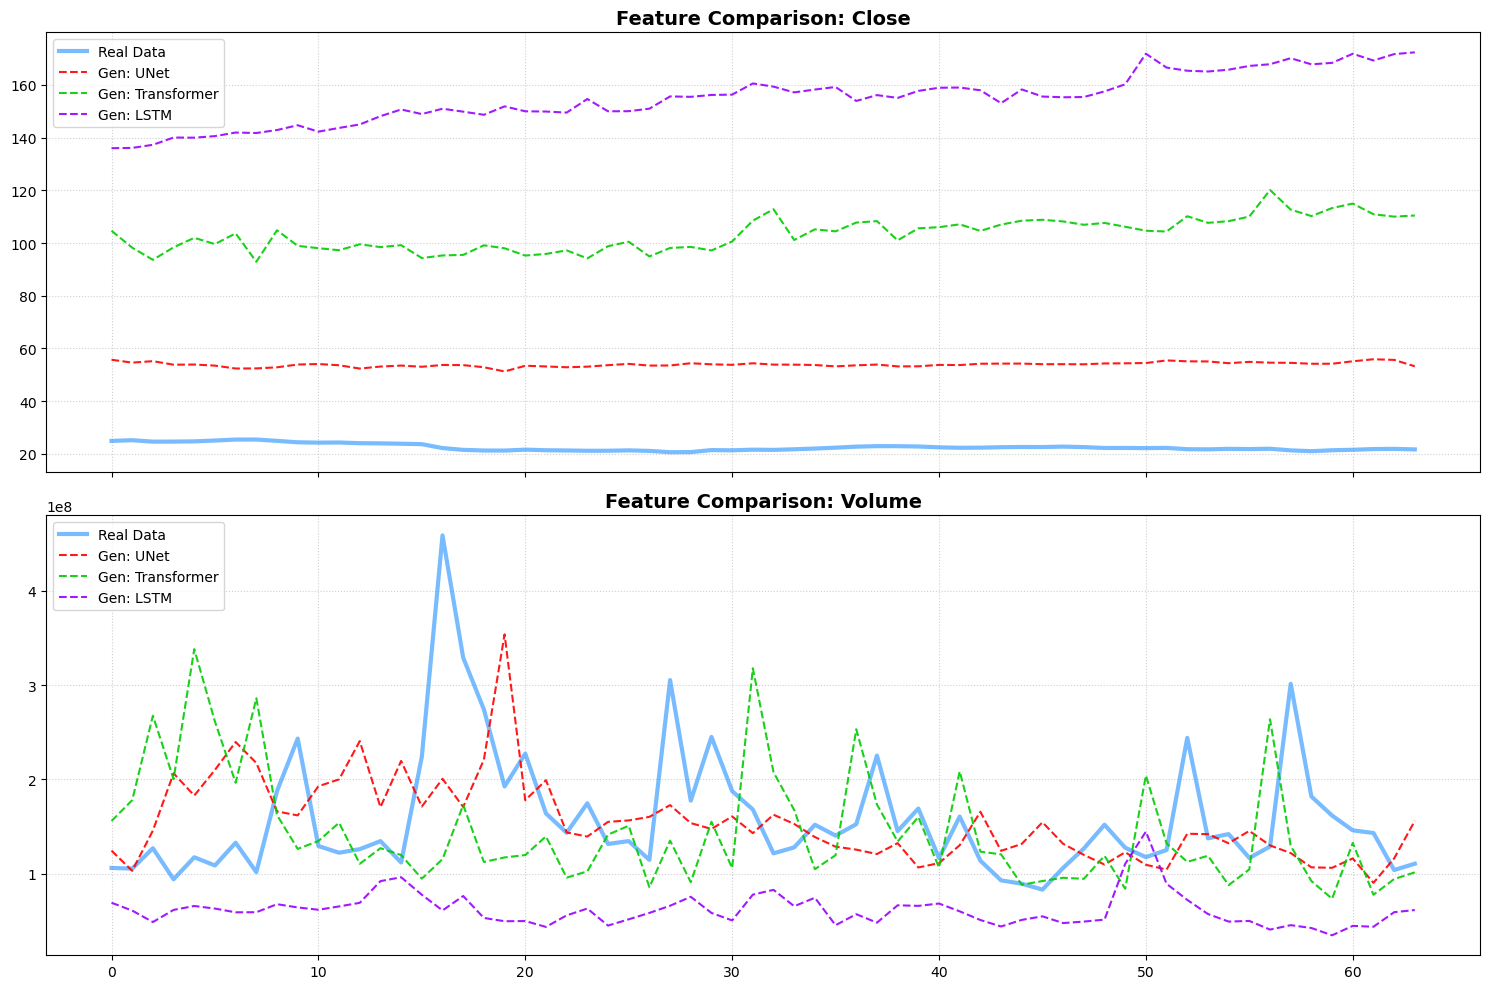

In [19]:
import os

path_unet = os.path.join(RESULTS_DIR,"checkpoints", "ddpm_unet_0496_20251128_171013.pt")
path_trans = os.path.join(RESULTS_DIR, "checkpoints", "ddpm_diffusiontransformer_0496_20251128_173134.pt")
path_lstm =  os.path.join(RESULTS_DIR, "checkpoints", "ddpm_diffusionlstm_0496_20251128_174737.pt")

# 2. 🛠️ สร้าง Config List จับคู่ Model ใน dict กับไฟล์ Checkpoint
models_to_compare = [
    {
        "name": "UNet", 
        "model": models["DDPM_UNet"],   # 👈 ดึงมาจาก dict ที่คุณสร้างไว้ข้างบน
        "path": path_unet, 
        "color": "#FF0000" # สีแดง
    },
    {
        "name": "Transformer", 
        "model": models["DDPM_Transformer"], # 👈 ดึงมาจาก dict
        "path": path_trans, 
        "color": "#00CC00" # สีเขียว
    },
    {
        "name": "LSTM", 
        "model": models["DDPM_LSTM"],   # 👈 ดึงมาจาก dict
        "path": path_lstm, 
        "color": "#9900FF" # สีม่วง
    }
]

# 3. 🚀 เรียกฟังก์ชันพล็อตเลย!
# (ต้องมีตัวแปร dataloader, diffusion, scaler, dataset อยู่ก่อนแล้วนะ)
plot_multi_model_comparison(
    dataloader=dataloader,
    models_config=models_to_compare,
    diffusion=diffusion,   # ใช้ object diffusion ตัวเดิมได้เลย (เพราะ noise schedule เหมือนกัน)
    scaler=dataset.get_scaler(),         # หรือ dataset.get_scaler()
    dataset=dataset,       # เพื่อเอาชื่อ Feature มาโชว์
    device=config["device"]
)

In [21]:
def plot_loss_comparison(models_config, log_scale=False):
    """
    โหลดไฟล์ Checkpoint ของแต่ละโมเดล แล้วดึง 'loss_history' มาพล็อตกราฟเปรียบเทียบ
    
    Args:
        models_config: List ของ Dict ที่เก็บ path และข้อมูลโมเดล
        log_scale: ถ้า True จะพล็อตแกน Y แบบ Logarithmic (เหมาะกับตอน Loss ต่างกันเยอะๆ)
    """
    plt.figure(figsize=(12, 7))
    
    print("📈 Plotting Loss Comparison...")

    for config in models_config:
        name = config['name']
        path = config['path']
        color = config.get('color', None) # ถ้าไม่มีสี ก็ปล่อยให้ Matplotlib สุ่มให้

        try:
            # โหลดเฉพาะ CPU ก็พอ (เร็วและประหยัดแรม)
            checkpoint = torch.load(path, map_location='cpu')
            
            # เช็คว่ามี key 'loss_history' ที่เราเซฟไว้ไหม
            if 'loss_history' in checkpoint:
                history = checkpoint['loss_history']
                epochs = range(1, len(history) + 1)
                
                # หาค่า Loss ต่ำสุดมาโชว์ใน Label ด้วย เท่ๆ
                min_loss = min(history)
                final_loss = history[-1]
                
                label_str = f"{name} (Min: {min_loss:.5f} | End: {final_loss:.5f})"
                
                plt.plot(epochs, history, label=label_str, color=color, linewidth=2, alpha=0.8)
            else:
                print(f"⚠️ Warning: ไม่พบ 'loss_history' ในไฟล์ของ {name}")
                # ถ้าไม่มี history อาจจะพล็อตจุดเดียวคือ loss ของ epoch นั้น (แก้ขัด)
                if 'loss' in checkpoint:
                    plt.scatter([checkpoint['epoch']], [checkpoint['loss']], label=f"{name} (Single Point)", color=color)

        except FileNotFoundError:
            print(f"❌ Error: หาไฟล์ไม่เจอ -> {path}")
        except Exception as e:
            print(f"❌ Error loading {name}: {e}")

    # ตกแต่งกราฟ
    plt.title("Training Loss Comparison (All Models)", fontsize=16, fontweight='bold')
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss (MSE)", fontsize=12)
    
    if log_scale:
        plt.yscale('log')
        plt.ylabel("Loss (Log Scale)", fontsize=12)
        
    plt.legend(fontsize=11)
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

📈 Plotting Loss Comparison...


/tmp/ipykernel_23078/2465422320.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location='cpu')


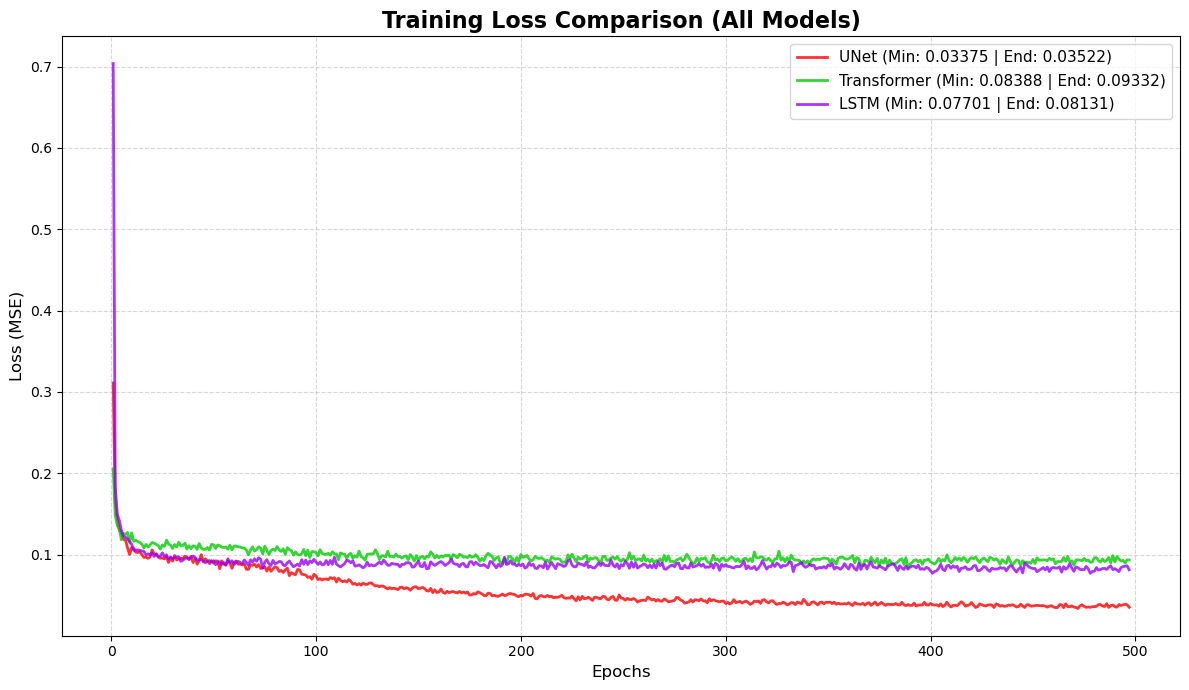

In [22]:
# เรียกใช้เลย!
plot_loss_comparison(models_to_compare)

# หรือถ้ากราฟมันลงเร็วมากจนดูยาก ลองเปิด Log Scale
# plot_loss_comparison(models_to_compare, log_scale=True)